In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Random seeds fixed for reproducibility")


Random seeds fixed for reproducibility


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Training samples: 50000
Test samples: 10000


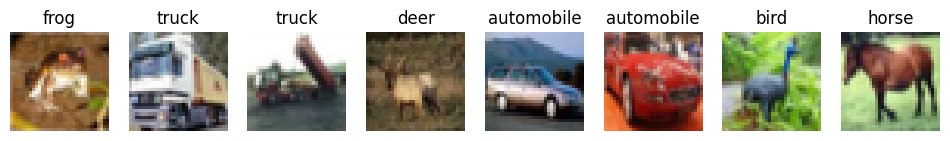

In [ ]:
import matplotlib.pyplot as plt
classes = train_dataset.classes

def show_images(dataset, num_images=8):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        image = image * 0.5 + 0.5
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(classes[label])
        plt.axis("off")
    plt.show()
show_images(train_dataset)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)
print("DataLoaders ready")


DataLoaders ready


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function and optimizer initialized")


Loss function and optimizer initialized


In [ ]:
def train_model(model, train_loader, test_loader, optimizer, epochs=10):
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_acc_history.append(test_accuracy)
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Acc: {train_accuracy:.2f}% | "
              f"Test Acc: {test_accuracy:.2f}%")

    return train_acc_history, test_acc_history


In [ ]:
train_acc, test_acc = train_model(
    model,
    train_loader,
    test_loader,
    epochs=10
)


Epoch [1/10] | Train Acc: 50.88% | Test Acc: 61.60%
Epoch [2/10] | Train Acc: 65.08% | Test Acc: 66.83%
Epoch [3/10] | Train Acc: 71.05% | Test Acc: 69.36%
Epoch [4/10] | Train Acc: 75.13% | Test Acc: 70.59%
Epoch [5/10] | Train Acc: 78.49% | Test Acc: 72.26%
Epoch [6/10] | Train Acc: 81.64% | Test Acc: 71.59%
Epoch [7/10] | Train Acc: 84.35% | Test Acc: 72.33%
Epoch [8/10] | Train Acc: 87.00% | Test Acc: 72.13%
Epoch [9/10] | Train Acc: 89.50% | Test Acc: 71.97%
Epoch [10/10] | Train Acc: 91.48% | Test Acc: 72.42%


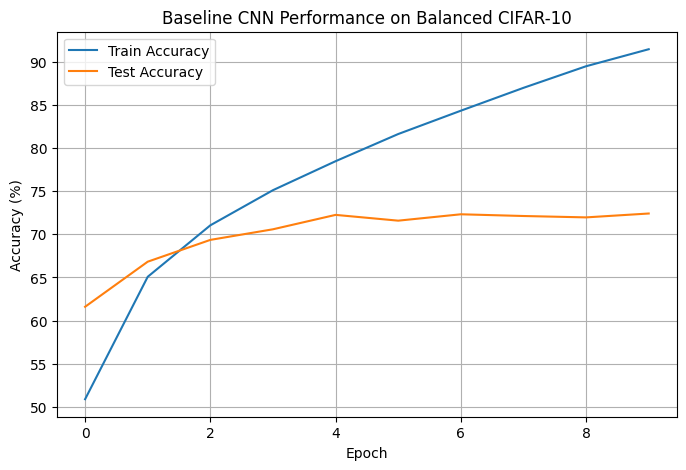

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Baseline CNN Performance on Balanced CIFAR-10")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def create_imbalanced_dataset(dataset, reduction_ratio=0.2, affected_classes=None):

    if affected_classes is None:
        affected_classes = []

    class_indices = {i: [] for i in range(10)}

    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []

    for label, indices in class_indices.items():
        if label in affected_classes:
            keep_count = int(len(indices) * reduction_ratio)
            selected_indices.extend(indices[:keep_count])
        else:
            selected_indices.extend(indices)

    return Subset(dataset, selected_indices)


In [ ]:
imbalanced_train_dataset = create_imbalanced_dataset(
    train_dataset,
    reduction_ratio=0.2,
    affected_classes=[5, 6, 7, 8, 9]
)
print("Original training size:", len(train_dataset))
print("Imbalanced training size:", len(imbalanced_train_dataset))


Original training size: 50000
Imbalanced training size: 30000


In [ ]:
from collections import Counter

def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

original_dist = get_class_distribution(train_dataset)
imbalanced_dist = get_class_distribution(imbalanced_train_dataset)
print("Original class distribution:")
print(original_dist)
print("\nImbalanced class distribution:")
print(imbalanced_dist)


Original class distribution:
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})

Imbalanced class distribution:
Counter({0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})


In [ ]:
imbalanced_train_loader = DataLoader(
    imbalanced_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

print("Imbalanced DataLoader ready")


Imbalanced DataLoader ready


In [ ]:
model_imbalanced = SimpleCNN().to(device)
optimizer_imbalanced = optim.Adam(model_imbalanced.parameters(), lr=0.001)
print("New model initialized for imbalanced training")


New model initialized for imbalanced training


In [ ]:
imbal_train_acc, imbal_test_acc = train_model(
    model_imbalanced,
    imbalanced_train_loader,
    test_loader,
    epochs=10
)


Epoch [1/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [2/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [3/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [4/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [5/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [6/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [7/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [8/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [9/10] | Train Acc: 16.60% | Test Acc: 9.99%
Epoch [10/10] | Train Acc: 16.60% | Test Acc: 9.99%


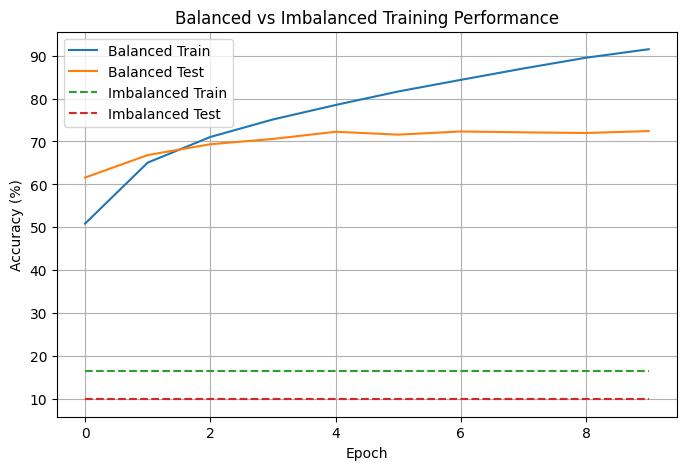

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Balanced Train")
plt.plot(test_acc, label="Balanced Test")
plt.plot(imbal_train_acc, label="Imbalanced Train", linestyle="--")
plt.plot(imbal_test_acc, label="Imbalanced Test", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Balanced vs Imbalanced Training Performance")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

imbal_preds, imbal_labels = get_predictions(model_imbalanced, test_loader)


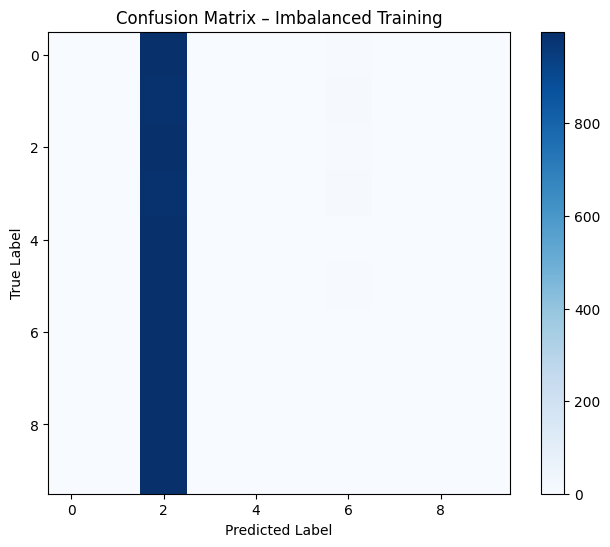

In [ ]:
cm = confusion_matrix(imbal_labels, imbal_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Imbalanced Training")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
print(classification_report(
    imbal_labels,
    imbal_preds,
    target_names=train_dataset.classes
))


              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.10      0.99      0.18      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.14      0.00      0.00      1000
        frog       0.06      0.00      0.01      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import f1_score

def run_experiment(reduction_ratio):
    print(f"\nRunning experiment with reduction ratio = {reduction_ratio}")
    imbalanced_dataset = create_imbalanced_dataset(
        train_dataset,
        reduction_ratio=reduction_ratio,
        affected_classes=[5, 6, 7, 8, 9]
    )

    loader = DataLoader(
        imbalanced_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_acc, test_acc = train_model(
        model,
        loader,
        test_loader,
        optimizer,
        epochs=10
    )

    preds, labels = get_predictions(model, test_loader)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {
        "reduction_ratio": reduction_ratio,
        "final_train_acc": train_acc[-1],
        "final_test_acc": test_acc[-1],
        "macro_f1": macro_f1
    }


In [ ]:
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

train_acc, test_acc = train_model(
    model,
    train_loader,
    test_loader,
    optimizer,
    epochs=5
)


Epoch [1/5] | Train Acc: 51.56% | Test Acc: 60.71%
Epoch [2/5] | Train Acc: 65.95% | Test Acc: 66.56%
Epoch [3/5] | Train Acc: 71.39% | Test Acc: 69.84%
Epoch [4/5] | Train Acc: 75.35% | Test Acc: 70.60%
Epoch [5/5] | Train Acc: 78.56% | Test Acc: 70.93%


In [ ]:
results = []
for ratio in [1.0, 0.7, 0.4, 0.2]:
    result = run_experiment(ratio)
    results.append(result)



Running experiment with reduction ratio = 1.0
Epoch [1/10] | Train Acc: 51.75% | Test Acc: 60.29%
Epoch [2/10] | Train Acc: 65.46% | Test Acc: 65.06%
Epoch [3/10] | Train Acc: 71.09% | Test Acc: 69.46%
Epoch [4/10] | Train Acc: 75.34% | Test Acc: 70.59%
Epoch [5/10] | Train Acc: 78.93% | Test Acc: 72.24%
Epoch [6/10] | Train Acc: 82.25% | Test Acc: 71.74%
Epoch [7/10] | Train Acc: 84.88% | Test Acc: 71.54%
Epoch [8/10] | Train Acc: 87.62% | Test Acc: 70.77%
Epoch [9/10] | Train Acc: 90.23% | Test Acc: 71.30%
Epoch [10/10] | Train Acc: 92.18% | Test Acc: 71.06%

Running experiment with reduction ratio = 0.7
Epoch [1/10] | Train Acc: 50.20% | Test Acc: 59.78%
Epoch [2/10] | Train Acc: 64.41% | Test Acc: 63.88%
Epoch [3/10] | Train Acc: 70.40% | Test Acc: 69.24%
Epoch [4/10] | Train Acc: 74.47% | Test Acc: 70.58%
Epoch [5/10] | Train Acc: 78.32% | Test Acc: 70.45%
Epoch [6/10] | Train Acc: 81.54% | Test Acc: 71.47%
Epoch [7/10] | Train Acc: 85.30% | Test Acc: 71.38%
Epoch [8/10] | Train 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df


,reduction_ratio,final_train_acc,final_test_acc,macro_f1
0,1.0,92.180000,71.06,0.710582
1,0.7,93.035294,70.74,0.706527
2,0.4,91.925714,68.69,0.691440
3,0.2,93.176667,63.63,0.634453


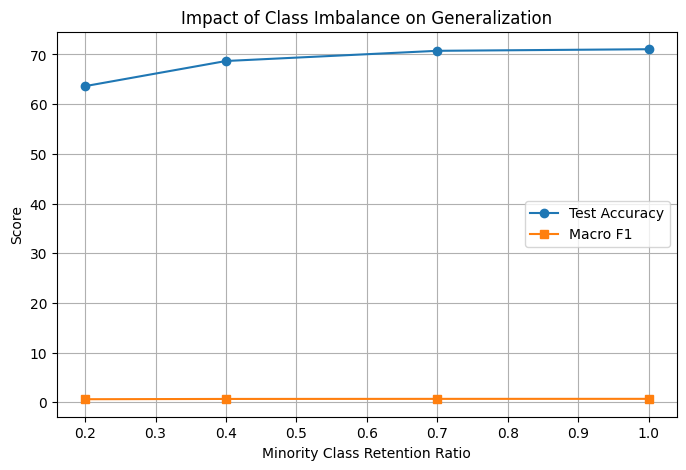

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["reduction_ratio"], results_df["final_test_acc"],
         marker="o", label="Test Accuracy")
plt.plot(results_df["reduction_ratio"], results_df["macro_f1"],
         marker="s", label="Macro F1")
plt.xlabel("Minority Class Retention Ratio")
plt.ylabel("Score")
plt.title("Impact of Class Imbalance on Generalization")
plt.legend()
plt.grid(True)
plt.show()
